# Imports

In [34]:
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.ndimage
from astropy import constants
speed_of_light_ms = constants.c.value
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit
import os
import sys
sys.path.append(os.path.abspath("/media/paul/One Touch11/wapiti_workflow"))
from wapiti import wapiti_tools, wapiti
from astropy.timeseries import LombScargle
import scipy.signal as signal 
from scipy.signal import find_peaks
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy import units as u
import lmfit # source: https://lmfit.github.io/lmfit-py/
from lmfit import minimize, Parameters, fit_report
import time
import multiprocessing
from wpca import PCA, WPCA, EMPCA
from scipy.stats.stats import pearsonr
import pacmap
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import random
import matplotlib

# Load TAPAS model

In [2]:
p1 = fits.open('/media/paul/One Touch11/SPIRou_Data/tapas_all_sp.fits') #2455897o_pp_e2dsff_tcorr_AB_GJ1286_GJ1286_lbl.fits') #### PATH TO CHANGE ####

tapas_other = p1[1].data['trans_o3'] + p1[1].data['trans_o2'] + p1[1].data['trans_n2o'] + p1[1].data['trans_co2'] + p1[1].data['trans_ch4'] - 4
tapas_water = p1[1].data['trans_h2o']
tapas_waves = p1[1].data['wavelength']

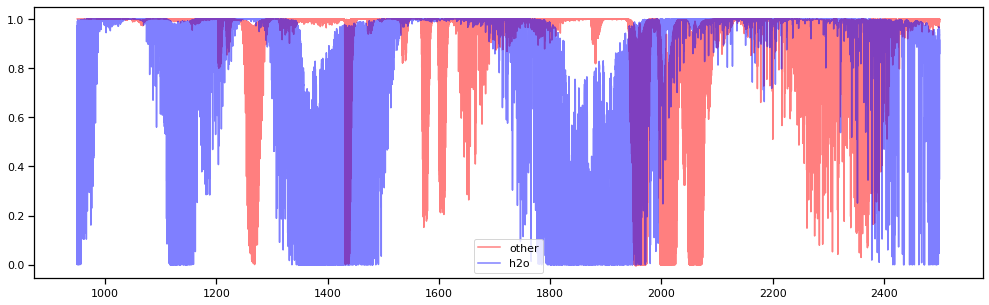

In [3]:
plt.figure(figsize=(17, 5))
plt.plot(tapas_waves, tapas_other, c='r', alpha=0.5, label='other')
plt.plot(tapas_waves, tapas_water, c='b', alpha=0.5, label='h2o')
plt.legend()
plt.show()

In [4]:
# convolution with the instrument resolution

fwhm_spirou = 16 #km/s
fwhm_spirou = (tapas_waves/(speed_of_light_ms/1000)) * fwhm_spirou
sig_spirou  = fwhm_spirou/(2*np.sqrt(2*np.log(2)))

# apply the broadening 

tapas_other_broad = scipy.ndimage.gaussian_filter1d(tapas_other, sigma=sig_spirou.mean(), mode='nearest')
tapas_water_broad = scipy.ndimage.gaussian_filter1d(tapas_water, sigma=sig_spirou.mean(), mode='nearest')

tapas_other = tapas_other_broad
tapas_water = tapas_water_broad 


In [5]:
# record telluric lines

other_wavelength = []
other_flux = []
for l in tqdm(range(1, len(tapas_waves)-1)):
    flx_l  = tapas_other[l]
    flx_1l = tapas_other[l-1]
    flx_l1 = tapas_other[l+1]
    if flx_l<flx_l1 and flx_l<flx_1l and flx_l < 1. :#and flx_l > 0. :
        other_wavelength.append(tapas_waves[l])
        other_flux.append(1-flx_l)

other_wavelength = np.array(other_wavelength)
other_flux = np.array(other_flux)

water_wavelength = []
water_flux = []
for l in tqdm(range(1, len(tapas_waves)-1)):
    flx_l  = tapas_water[l]
    flx_1l = tapas_water[l-1]
    flx_l1 = tapas_water[l+1]
    if flx_l<flx_l1 and flx_l<flx_1l and flx_l < 1. :# and flx_l > 0. :
        water_wavelength.append(tapas_waves[l])
        water_flux.append(1-flx_l)

water_wavelength = np.array(water_wavelength)
water_flux = np.array(water_flux)


100%|██████████| 374497/374497 [00:00<00:00, 2905704.78it/s]


In [6]:
def Gauss(x, a, x0, sigma):
    return 1 - a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def get_tellu_params(wavelengths, fluxes):
    
    n = len(fluxes)
    i = 1
    a_t, x_t, sig_t = [], [], []
    while i < n-1:
        if fluxes[i-1]>fluxes[i] and fluxes[i+1]>fluxes[i] and fluxes[i] > 0. :
            left = i 
            while left > 0 and fluxes[left-1] >= fluxes[left]:
                left -= 1    
            right = i 
            while right < n-1 and fluxes[right+1] >= fluxes[right]:
                right += 1
                
            line_wavelengths = wavelengths[left:right+1]
            line_fluxes = fluxes[left:right+1]
            
            x0 = wavelengths[i]
            
            #Fit Gauss 
            try :
                popt, pcov = curve_fit(
                    lambda x, a0, sigma: Gauss(x, a0, x0, sigma),
                    line_wavelengths,
                    line_fluxes,
                    p0=[1-fluxes[i], 0.001]  # Provide reasonable initial guesses
                )
                a0, sig0 = popt
                a_t.append(a0)
                x_t.append(x0)
                sig_t.append(np.abs(sig0))
            except : 
                pass
            
            i = right
        else :
            i +=1
            
    return(np.array(a_t), np.array(x_t), np.array(sig_t))

In [7]:
a_tellu_other, wave_tellu_other, sig_tellu_other = get_tellu_params(tapas_waves, tapas_other)
a_tellu_water, wave_tellu_water, sig_tellu_water = get_tellu_params(tapas_waves, tapas_water)

# Load STAR data

In [8]:
target = 'EV_LAC'
template = target
target = target + '_' + template

cwd = "/media/paul/One Touch11/wapiti_workflow" ## base work directory

def get_data(target):

    files = os.listdir(cwd+'/lblrv/'+target)

    times_lbl = []
    d2vs_all = []
    dd2vs_all = []

    berv = []
    order = []
    snrs_per_ord = []
    airmass = []
    h2o = []
    other_species = []
 
    for file in tqdm(files, leave=False):
        lbl = fits.open(cwd+'/lblrv/'+target+'/'+file)
        lbl_data = lbl[1].data
        lbl_header = lbl[0].header
        lbl.close()

        d2v_all = lbl_data['d2v']
        dd2v_all = lbl_data['sd2v']
        
        order = lbl_data['ORDER']
        snrs_per_ord.append([lbl_header['EXTSN000'], lbl_header['EXTSN001'], lbl_header['EXTSN002'], lbl_header['EXTSN003'], lbl_header['EXTSN004']
                     , lbl_header['EXTSN005'], lbl_header['EXTSN006'], lbl_header['EXTSN007'], lbl_header['EXTSN008'], lbl_header['EXTSN009']
                     , lbl_header['EXTSN010'], lbl_header['EXTSN011'], lbl_header['EXTSN012'], lbl_header['EXTSN013'], lbl_header['EXTSN014']
                     , lbl_header['EXTSN015'], lbl_header['EXTSN016'], lbl_header['EXTSN017'], lbl_header['EXTSN018'], lbl_header['EXTSN019']
                     , lbl_header['EXTSN020'], lbl_header['EXTSN021'], lbl_header['EXTSN022'], lbl_header['EXTSN023'], lbl_header['EXTSN024']
                     , lbl_header['EXTSN025'], lbl_header['EXTSN026'], lbl_header['EXTSN027'], lbl_header['EXTSN028'], lbl_header['EXTSN029']
                     , lbl_header['EXTSN030'], lbl_header['EXTSN031'], lbl_header['EXTSN032'], lbl_header['EXTSN033'], lbl_header['EXTSN034']
                     , lbl_header['EXTSN035'], lbl_header['EXTSN036'], lbl_header['EXTSN037'], lbl_header['EXTSN038'], lbl_header['EXTSN039']
                     , lbl_header['EXTSN040'], lbl_header['EXTSN041'], lbl_header['EXTSN042'], lbl_header['EXTSN043'], lbl_header['EXTSN044']
                     , lbl_header['EXTSN045'], lbl_header['EXTSN046'], lbl_header['EXTSN047'], lbl_header['EXTSN048']])
        
        try:
            times_lbl.append(lbl_header['BJD'])
            d2vs_all.append(d2v_all)
            dd2vs_all.append(dd2v_all)
            berv.append(lbl_header['BERV'])
            airmass.append(lbl_header['AIRMASS'])
            h2o.append(lbl_header['TLPEH2O'])
            other_species.append(lbl_header['TLPEOTR'])

        except:
            pass
    times_lbl = np.array(times_lbl)
    
    # Step 4: Use these indexes to filter each list
    d2vs_all = np.array(d2vs_all)
    dd2vs_all = np.array(dd2vs_all)
    order = np.array(order)
    berv = np.array(berv)
    h2o = np.array(h2o)
    other_species = np.array(other_species)
    airmass = np.array(airmass)
    waves = (lbl_data['WAVE_START'] + lbl_data['WAVE_END'])/2.
    wave_start = lbl_data['WAVE_START']
    wave_end = lbl_data['WAVE_END']
    wave_depth = lbl_data['LINE_DEPTH']
    snrs_per_ord = np.array(snrs_per_ord)
    #snrs_per_ord = [np.mean(snrs_per_ord[:,i]) for i in range(snrs_per_ord.shape[1])]
    
    
    return times_lbl, d2vs_all, dd2vs_all, waves, berv, wave_start, wave_end, wave_depth, order, snrs_per_ord, airmass, h2o, other_species

times_lbl, d2vs_all, dd2vs_all, waves, berv, wave_start, wave_end, depth, order, snr_per_order, airmass, h2o, other_species = get_data(target)  


d2vs_binned = []
dd2vs_binned = []

for idx in tqdm(range(d2vs_all.shape[1]), leave=False):

    time_binned, d2v, dd2v = wapiti_tools.night_bin(times_lbl, d2vs_all[:, idx], dd2vs_all[:, idx])
    d2vs_binned.append(d2v)
    dd2vs_binned.append(dd2v)

d2vs_binned = np.array(d2vs_binned).T
dd2vs_binned = np.array(dd2vs_binned).T

snrs_order = []
for o in range(len(snr_per_order[0])):
    __, snro = wapiti_tools.night_bin(times_lbl, snr_per_order[:, o])
    snrs_order.append(snro)

snr_per_order = np.array(snrs_order).T

_, berv = wapiti_tools.night_bin(times_lbl, berv)
_, airmass = wapiti_tools.night_bin(times_lbl, airmass)
_, h2o = wapiti_tools.night_bin(times_lbl, h2o)
_, other_species = wapiti_tools.night_bin(times_lbl, other_species)

print('Number of lines before rejection: ', d2vs_binned.shape[1])
valid = wapiti_tools.compute_valid_lines(d2vs_binned.T, time_binned, 0.5)
print('Number of lines after rejection: ', d2vs_binned[:, valid].shape[1])


print(waves.shape)
waves = waves[valid]
order = order[valid]
wave_start = wave_start[valid]
wave_end = wave_end[valid]
depth = -depth[valid]
print(waves.shape)

valid_depth = depth > 0.

d2vs_used = np.copy(d2vs_binned)[:, valid][:, valid_depth]
dd2vs_used = np.copy(dd2vs_binned)[:, valid][:, valid_depth]
waves = waves[valid_depth]
order = order[valid_depth]
wave_start = wave_start[valid_depth]
wave_end = wave_end[valid_depth]
depth = depth[valid_depth]
print(waves.shape)


Number of lines before rejection:  21473
Number of lines after rejection:  15381
(21473,)
(15381,)
(15325,)


## Load GP

In [9]:
time_grid, GP, BERV  = np.load('/home/paul/Bureau/IRAP/dLWPCA/SPCAndie/V_5_0/EV_Lac_T_B_Berv.npy')

GP -= np.mean(GP)
GP = GP/np.max(np.abs(GP)) #Normalize the injected signal 

Prot = 4.3615

## Remove last bin and low SNR observation

(168,)
(159,)


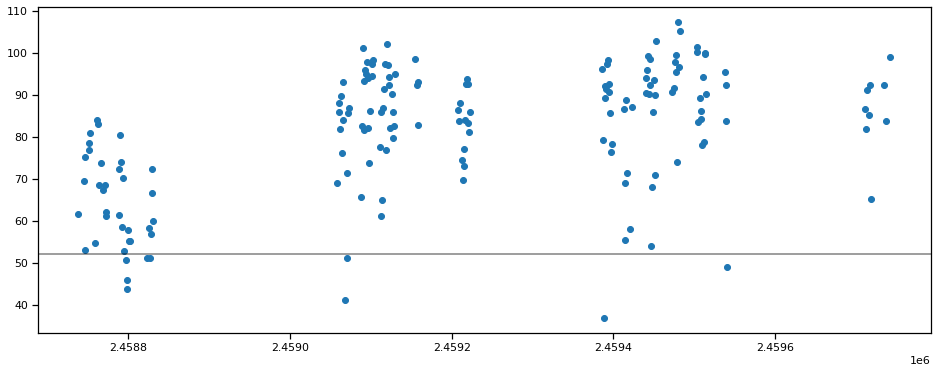

In [10]:
#remove last bin

time_binned   = np.delete(time_binned, -1)
snr_per_order = np.delete(snr_per_order, -1, axis=0)
d2vs_used = np.delete(d2vs_used, -1, axis=0)
dd2vs_used = np.delete(dd2vs_used, -1, axis=0)
h2o = np.delete(h2o, -1)
other_species = np.delete(other_species, -1)

plt.figure(figsize=(16, 6))
plt.plot(time_binned, np.mean(snr_per_order, axis=1), 'o')
plt.axhline(52, c='k', alpha=0.5)

#remove low snr 
print(time_grid.shape)

i = 0
while i < len(time_grid):
    if np.mean(snr_per_order[i]) < 52:# or dvodd[i] < -82580:
        time_grid     = np.delete(time_grid, i)
        time_binned   = np.delete(time_binned, i)
        snr_per_order = np.delete(snr_per_order, i, axis=0)
        d2vs_used     = np.delete(d2vs_used, i, axis=0)
        dd2vs_used    = np.delete(dd2vs_used, i, axis=0)
        h2o           = np.delete(h2o, i)
        other_species = np.delete(other_species, i)
        GP            = np.delete(GP, i)        
        BERV          = np.delete(BERV, i)
    else :
        i+=1

print(time_grid.shape)


## Record dLW amplitude

In [11]:
def get_dlw_amplitude(time, dlw):
        tt, tw = popnan(time, dlw) #not Wrong, popnan returns t first 
        per = 4.3615
        freq = 2*np.pi/per
        #amplitude = np.sqrt(LombScargle(tt, tw).power(freq, normalization='psd')/len(tt))*2
        amplitude = np.sqrt(signal.lombscargle(tt, tw, freq)*4/len(tt))
        return amplitude 
        
        
def popnan(t, X):
    # Was implemented to handle data with NaNs in it but in fact not needed here
    Xout  = X[np.invert(np.isnan(X))]
    tout  = t[np.invert(np.isnan(X))]
    return(tout, Xout)

In [12]:
dlw_amp = np.zeros(d2vs_used.shape[1])
count = 0
for i in tqdm(range(d2vs_used.shape[1])):
    dlw_amp[i] = get_dlw_amplitude(time_binned, d2vs_used[:, i])   

100%|██████████| 15325/15325 [00:00<00:00, 100418.86it/s]


# Load Template

In [13]:
templates = fits.open('/media/paul/One Touch11/wapiti_workflow/templates/Template_s1dv_EV_LAC_sc1d_v_file_AB.fits')
tempwave = templates[1].data['wavelength']
tempflux = templates[1].data['flux']

In [14]:
def find_continuum(wavelength, flux, n=4) :
        w = wavelength
        f = flux

        peaks_idx, _ = find_peaks(f)
        new_w = w[peaks_idx]
        new_f = f[peaks_idx]

        for i in range (0,n):
            peaks_idx, _ = find_peaks(new_f) 
            new_w = new_w[peaks_idx]
            new_f = new_f[peaks_idx]

        spectrum = Spectrum1D(flux=new_f*u.Jy, spectral_axis=new_w*u.nm)
        g1_fit = fit_generic_continuum(spectrum)
        y_fit = g1_fit(w*u.nm) #g1_fit est une fonction 

        continuum = y_fit.value
        return continuum 

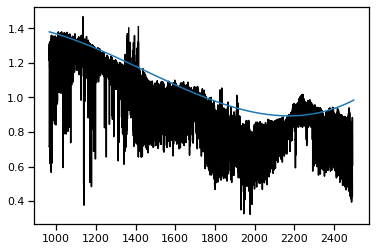

In [15]:
continuum = find_continuum(tempwave, tempflux)
plt.plot(tempwave, tempflux, 'k')
plt.plot(tempwave, continuum)
tempflux /= continuum 

# TOY MODEL

In [16]:
def bouchy_equation(params, d1, d2, diff, x):
    d0v = params.get('d0v').value
    dv  = params.get('dv').value
    d2v = params.get('d2v').value
    zero = d0v + dv*d1*x + d2v*d2*x*x - diff
    return(zero)

def compute_lbl(line, template, x, x0, display=False):
    x = x
    d1 = np.gradient(template, x)
    d2 = np.gradient(d1, x)
    diff_seg = line - template
    #initialize
    params_ini = Parameters()

    params_ini.add('d0v', value=0, min=-np.inf, max=np.inf)
    params_ini.add('dv', value=0, min=-np.inf, max=np.inf)
    params_ini.add('d2v', value=0, min=-np.inf, max=np.inf)
    #fit
    out = minimize(bouchy_equation, params_ini, args = (d1, d2, diff_seg, x))
    #result
    if display:
        plt.plot(x, line, label='line')
        plt.plot(x, bouchy_equation(out.params, d1, d2, diff_seg, x)+diff_seg+template, label='fit')
        plt.legend()
        plt.show()
        

    d2v  = out.params['d2v'].value
    sd2v = out.params['d2v'].stderr

    dlw = d2v*speed_of_light_ms*speed_of_light_ms
    sdlw = sd2v*speed_of_light_ms*speed_of_light_ms

    return(dlw, sdlw)
    

def doppler_shift(wavegrid: np.ndarray, velocity: float) -> np.ndarray:
    """
    Apply a dopplershift
    
    :param wavegrid: wave grid to shift
    :param velocity: float, velocity expressed in m/s
    
    :return: np.ndarray, the updated wave grid
    """
    # relativistic calculation (1 - v/c)
    part1 = 1 - (velocity * 1000 / speed_of_light_ms)
    # relativistic calculation (1 + v/c)
    part2 = 1 + (velocity * 1000 / speed_of_light_ms)
    # return updated wave grid
    return wavegrid * np.sqrt(part1 / part2)


#Noise Model

def custom_psd_function(freq_grid):
    a_low, b_low = 3.42e-4, 0.69
    a_mid = 3.59e-4
    a_high, b_high, c_high = 1.77e-5, -3.24, -0.86
    f_break_high = 8.
    f_break_low  = 1.
    psd = np.zeros_like(freq_grid)
    for f in range(len(freq_grid)):
        # low frequency
        if freq_grid[f] <= f_break_low :
            psd[f] = a_low/(freq_grid[f]**b_low)
        # high frequency
        elif freq_grid[f] >= f_break_high :
            psd[f] = a_high * freq_grid[f] ** (-b_high + c_high * np.log(freq_grid[f]))
        else :
            psd[f] = a_mid
    return(psd)
    

def generate_noise_from_psd(psd_func, n_samples, sample_rate): 
    """
    Generate a signal from a given PSD
    
    Parameters:
        psd_func: function
            User's PSD function.
        n_samples: int
            Number of samples to generate.
        sample_rate: float
            sampling rate.
    
    Returns:
        y: ndarray
            Signal generated with the desired PSD.
    """
    # Frequency bins
    freqs = np.fft.rfftfreq(n_samples, d=1/sample_rate)
    valid = freqs > 0.
    freqs = freqs[valid]
    
    #Compute the desired amplitude (sqrt of the PSD)
    psd_target = psd_func(freqs)
    amplitude_spectrum = np.sqrt(psd_target)
    
    #Generate white noise
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs)))
    frequency_domain = amplitude_spectrum * random_phases
    
    #Turn into signal 
    y = np.fft.irfft(frequency_domain, n=n_samples)
    
    #Normalize
    y /= np.std(y)
    
    return(y)

In [17]:
class Line: 
    def __init__(self, i):
        self.wavestart  = wave_start[i]
        self.waveend    = wave_end[i]
        self.wavecenter = (wave_start[i] + wave_end[i])/2
        self.ampli = dlw_amp[i]
        self.times = time_grid #time_binned
        self.berv  = BERV
        self.prot  = Prot
        self.order = order[i]
        self.snr   = snr_per_order[:, self.order]
        self.h2o   = h2o
        self.other = other_species
        self.valid_flag = True
    
    def template_to_template(self, display = False):
        # idxs in template
        line_temp_wave = np.array([wi for wi in tempwave if self.wavestart <= wi <= self.waveend])
        line_temp_flux = np.array([fi for wi, fi in zip(tempwave, tempflux) if self.wavestart <= wi <= self.waveend])
        
        #Fit Gauss 
        bounds = ((0, -np.inf, -np.inf), (1., np.inf, np.inf))
        popt, pcov = [], []
        
        mean  = sum(line_temp_wave * line_temp_flux) / sum(line_temp_flux)
        sigma = np.sqrt(sum(line_temp_flux * (line_temp_wave - mean)**2) / sum(line_temp_flux))
        
        p0 = [min(line_temp_flux), mean, sigma]
        
        try :
            popt, pcov = curve_fit(Gauss, line_temp_wave, line_temp_flux, p0, bounds=bounds)
            
            self.template = Gauss(line_temp_wave, *popt)
            self.depth, self.lambda_0, self.width = popt 
        except :
            self.valid_flag = False
        self.x = line_temp_wave
        
        if display :
            plt.plot(line_temp_wave, line_temp_flux, 'b+:', label='data')
            plt.plot(line_temp_wave, Gauss(line_temp_wave, *popt), 'r-', label='fit')
            plt.show()
            return(line_temp_flux)
    
    def init_tellurics(self): 
        # get tellurics
        tellu= []
        # h2o tellurics
        for t in range(len(wave_tellu_water)):     
            x_h2o = wave_tellu_water[t]
            if self.wavestart <= x_h2o <= self.waveend:     
                tellu_dic = {
                    "Type": "Water",
                    "depth": a_tellu_water[t],
                    "lambda": x_h2o,
                    "sigma": sig_tellu_water[t],
                }
                tellu.append(tellu_dic)
        # other tellurics
        for t in range(len(wave_tellu_other)):
            x_other = wave_tellu_other[t]
            if self.wavestart <= x_other <= self.waveend:
                tellu_dic = {
                    "Type": "Other",
                    "depth": a_tellu_other[t],
                    "lambda": x_other,
                    "sigma": sig_tellu_other[t],
                }
                tellu.append(tellu_dic)
                
        self.tellu = np.array(tellu)

    
    def get_w_variations(self):
        if self.valid_flag:
            measured_widthvariation = self.ampli * GP #width_variation(self.ampli, self.times, self.prot)
            wgdwg = 8*np.log(2)* measured_widthvariation / self.width
            self.widthvariation =  (self.lambda_0**2) * wgdwg / (speed_of_light_ms**2)
        
    def apply_tellu(self, berv, tlpe_h2o, tlpe_other):
        tellu_line = np.zeros_like(self.x)
        for t in range(len(self.tellu)):
            rng_correction = np.random.normal(0.03, 0.01)
            tellu_wvl_shift = doppler_shift(self.tellu[t]["lambda"], berv)
            if self.tellu[t]["Type"] == "Water":
                tlpe = tlpe_h2o
            elif self.tellu[t]["Type"] == "Other":
                tlpe = tlpe_other
            else :
                tlpe = 1.
            tellu_line += Gauss(self.x, rng_correction*self.tellu[t]["depth"]**tlpe, tellu_wvl_shift, self.tellu[t]["sigma"]) - 1
        return tellu_line
        
    def runlbl(self, display=False):
        DLW, SDLW = np.zeros_like(self.times), np.zeros_like(self.times)
        if self.valid_flag:
            for i in range(len(self.times)):
                #step i width variation
                line = Gauss(self.x, self.depth, self.lambda_0, self.width + self.widthvariation[i])
                #step ii tellu
                if len(self.tellu)>=1:
                    line += self.apply_tellu(self.berv[i], self.h2o[i], self.other[i])
                #step iii add noise
                line += generate_noise_from_psd(custom_psd_function, len(self.x), np.mean(self.x[1:]-self.x[:-1])) / self.snr[i]
                if display:
                    plt.plot(self.x, line, c='g', alpha=0.04)
                
                #step iv fit
                try :
                    DLW[i], SDLW[i] = compute_lbl(line, self.template, self.x, self.lambda_0)
                except :
                    DLW[i], SDLW[i] = np.nan, np.nan  
        else :
            DLW[:], SDLW[:] = np.nan, np.nan  
        if np.sum(np.isnan(DLW)) >= len(self.times)/2 :
            self.valid_flag = False
        self.dlw = DLW
        self.sdlw = SDLW

## Run ! 

In [18]:
n_lines = waves.shape[0]

def process_iteration(l):
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    line_l = Line(l)
    line_l.template_to_template()
    line_l.init_tellurics()
    line_l.get_w_variations()
    line_l.runlbl()
    return(line_l)

#run
with multiprocessing.Pool() as pool:
    results = list(tqdm(pool.imap_unordered(process_iteration, np.arange(n_lines)), total=n_lines))

    
line_bigtable = np.array(results)

100%|██████████| 15325/15325 [12:10<00:00, 20.98it/s] 


In [19]:
#remove invalid lines
valid_lines = [l.valid_flag for l in line_bigtable]
line_bigtable = line_bigtable[valid_lines]
n_lines = len(line_bigtable)
print(n_lines)

14758


In [20]:
D2V_all  = np.zeros((n_lines, len(time_grid)))
sD2V_all = np.zeros((n_lines, len(time_grid)))
amplin = np.zeros(n_lines)
tellud = []
count = 0
for l in tqdm(range(n_lines)):
    amplin[l] = line_bigtable[l].ampli
    tel = line_bigtable[l].tellu
    if len(tel)>=1:
        count += 1
        for t in tel:
            tellud.append(t["depth"])
    for t in range(len(time_grid)):
        D2V_all[l][t]  = line_bigtable[l].dlw[t]
        sD2V_all[l][t] = line_bigtable[l].sdlw[t]

100%|██████████| 14758/14758 [00:01<00:00, 14261.00it/s]


In [21]:
def odd_ratio_mean(value, err, odd_ratio=1e-4, nmax=10):
    # Vectorized implementation of odd_ratio_mean
    
    # Mask NaNs
    mask = np.isfinite(value) & np.isfinite(err)
    if not np.any(mask):
        return np.nan, np.nan

    # Apply mask
    value = value[mask]
    err = err[mask]

    # Initial guess
    guess = np.nanmedian(value)

    for nite in range(nmax):
        nsig = (value - guess) / err
        gg = np.exp(-0.5 * nsig**2)
        odd_bad = odd_ratio / (gg + odd_ratio)
        odd_good = 1 - odd_bad
        w = odd_good / err**2
        guess = np.nansum(value * w) / np.nansum(w)

    bulk_error = np.sqrt(1 / np.nansum(odd_good / err**2))

    return guess, bulk_error

In [22]:
d2v_0, std_d2v_0 = [], []
for idx in tqdm(range(len(time_grid)), leave=False):
    d2v_temp, std_d2v_temp = odd_ratio_mean(D2V_all[:,idx], sD2V_all[:,idx])
    d2v_0.append(d2v_temp)
    std_d2v_0.append(std_d2v_temp)
d2v_0, std_d2v_0 = np.array(d2v_0), np.array(std_d2v_0)

In [23]:
# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_d2vs = np.ma.MaskedArray((D2V_all), mask=np.isnan((D2V_all)))
ma_dd2vs = np.ma.MaskedArray((sD2V_all), mask=np.isnan((sD2V_all)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_d2vs, weights=1/ma_dd2vs**2, axis=1)
variance = np.ma.average((ma_d2vs-average.reshape(-1, 1))**2, weights=1/ma_dd2vs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_d2vs = average.data.reshape(-1, 1)
std_d2vs = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
RV2 = (np.copy(D2V_all)-mean_d2vs)/std_d2vs
dRV2 = np.copy(sD2V_all)/std_d2vs

weights = 1. / dRV2 # Not a mistake - The wPCA is coded in a way that 1/dX as a weights variable here means using 1/dX² as an effective weights
weights[np.isnan(RV2)] = 0
pca_d2v = WPCA(n_components=RV2.shape[1])
pca_d2v.fit(RV2, weights=weights)

WPCA(n_components=159)

W1before fap  0.0
W1before fap  -41.98692005182134
72.21662837448775


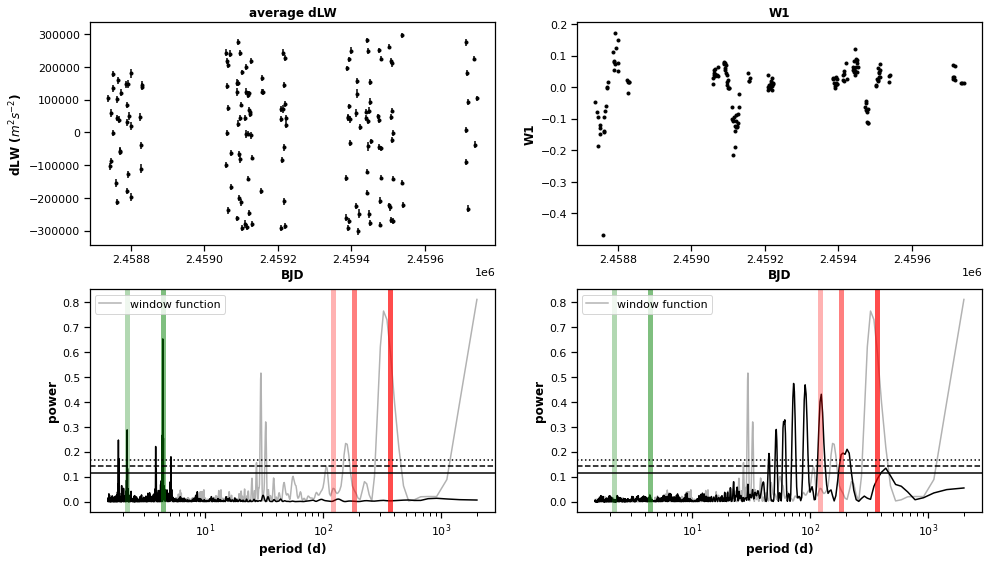

In [30]:
## Both figures 
wf = np.ones(len(time_grid))

fig, ax = plt.subplots(2, 2, figsize=(16,9))

ax[0, 0].errorbar(time_grid, d2v_0, yerr=std_d2v_0, fmt='.k')
ax[0, 0].set_ylabel("dLW ($m^2 s^{-2}$)", size=12, weight='bold')
ax[0, 0].set_xlabel("BJD", size=12, weight='bold')
ax[0, 0].set_title("average dLW", size=12, weight='bold')

frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1, 0].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
frequency, power = LombScargle(time_grid, d2v_0).autopower(minimum_frequency=1/2000, maximum_frequency=1/1.5)
ax[1, 0].plot(1/frequency, power, 'k')
ax[1, 0].set_ylabel("power", size=12, weight='bold')
ax[1, 0].set_xlabel("period (d)", size=12, weight='bold')
ax[1, 0].set_xscale('log')
ax[1, 0].axvline(365.25, color='r', alpha=0.7, linewidth=5)
ax[1, 0].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
ax[1, 0].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
ax[1, 0].axvline(Prot, color='g', alpha=0.5, linewidth=5)
ax[1, 0].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)
#ax[1, 0].set_ylim(0,0.6)
ax[1, 0].legend()
ls = LombScargle(time_grid, d2v_0)
fap = ls.false_alarm_level(0.1)
ax[1, 0].axhline(fap, linestyle='-', color='k')
fap = ls.false_alarm_level(0.01)
ax[1, 0].axhline(fap, linestyle='--', color='k')
fap = ls.false_alarm_level(0.001)
ax[1, 0].axhline(fap, linestyle=':', color='k')

ax[0, 1].plot(time_grid, -pca_d2v.components_[0], 'k.')
ax[0, 1].set_ylabel('W1', size=12, weight='bold')
ax[0, 1].set_xlabel("BJD", size=12, weight='bold')
ax[0, 1].set_title("W1", size=12, weight='bold')

frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1, 1].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
frequency, power = LombScargle(time_grid, pca_d2v.components_[0]).autopower(minimum_frequency=1/2000, maximum_frequency=1/1.5)
ax[1, 1].plot(1/frequency, power, 'k')
ax[1, 1].set_ylabel("power", size=12, weight='bold')
ax[1, 1].set_xscale('log')
ax[1, 1].axvline(365.25, color='r', alpha=0.7, linewidth=5)
ax[1, 1].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
ax[1, 1].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
ax[1, 1].axvline(Prot, color='g', alpha=0.5, linewidth=5)
ax[1, 1].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)
ax[1, 1].set_xlabel("period (d)", size=12, weight='bold')
ax[1, 1].legend()
ls = LombScargle(time_grid, pca_d2v.components_[0])
fap = ls.false_alarm_level(0.1)
ax[1, 1].axhline(fap, linestyle='-', color='k')
fap = ls.false_alarm_level(0.01)
ax[1, 1].axhline(fap, linestyle='--', color='k')
fap = ls.false_alarm_level(0.001)
ax[1, 1].axhline(fap, linestyle=':', color='k')
Prow = power[np.argmin(np.abs(frequency - 1/Prot))]
print('W1before fap ', np.log(ls.false_alarm_probability(Prow)))
print('W1before fap ', np.log(ls.false_alarm_probability(power.max())))
freqmaxw1b = np.argmax(power)
print(1/frequency[freqmaxw1b])
plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_ToyModel_overall.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [31]:
print(pearsonr(GP, d2v_0))
print(pearsonr(GP, pca_d2v.components_[0]))
print(pearsonr(BERV, pca_d2v.components_[0]))

PearsonRResult(statistic=0.9845019845603554, pvalue=1.2951323860953389e-120)
PearsonRResult(statistic=0.12680108522204267, pvalue=0.11122280072269648)
PearsonRResult(statistic=-0.07954970317055467, pvalue=0.31888603544891725)


# Run PaCMAP

In [36]:
period_grid = np.logspace(np.log(1.25), 3, 1000)
new_freq = 1/period_grid
frequency = new_freq # periodogram frequency grid

def periodo(ind, X, dX, t, show = False):
    t, dlw, sdlw = popnan(ind, X, dX, t)
    ls = LombScargle(t, dlw, sdlw)#.autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5)
    power = ls.power(frequency)
    max_freq = frequency[np.argmax(power)]
    max_pow = np.max(power)
    max_fap = -np.log(ls.false_alarm_probability(max_pow))
    return(power, 1/max_freq, max_pow, max_fap)

def popnan(ind, X, dX, t):
    Xout = X[ind, np.invert(np.isnan(X[ind]))]
    tout = t[np.invert(np.isnan(X[ind]))]
    dXout = dX[ind, np.invert(np.isnan(X[ind]))]
    return(tout, Xout, dXout)

def PacMapDisp(X, n_neighbors=10, MN_rate=0.5, FP_rate=2.0):
    random.seed(110)
    X = X.reshape(X.shape[0], -1)
    # Initialize the pacmap instance
    # Setting n_neighbors to "None" leads to an automatic parameter selection
    # choice shown in "parameter" section of the README file.
    # Notice that from v0.6.0 on, we rename the n_dims parameter to n_components.
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors, MN_ratio=MN_rate, FP_ratio=FP_rate, random_state = 110, apply_pca = True)
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X, init="pca")
    # visualize the embedding
    fig = plt.figure(figsize=(16,10))
    scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="nipy_spectral", c=mf, s=10*mfap, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(label='Period [d]')
    cb.set_label(label='Period [d]', size='large', weight='bold')
    cb.ax.tick_params(labelsize='large')
    handles, labels = scatter.legend_elements(prop='sizes', alpha = 0.6)
    #print(handles)
    #labels = [float(labels[i]) for i in range(len(labels))]
    #labels = np.sqrt(labels)/25
    #labels = [str(labels[i]) for i in range(len(labels))]
    plt.legend(handles, labels, title = '$- 10 logFAP_{max}$', prop={'size':12, 'weight':'bold'})
 
    plt.axis('off')
    plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_Simu_PacMap.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return(X_transformed)

100%|██████████| 14758/14758 [01:20<00:00, 183.36it/s]


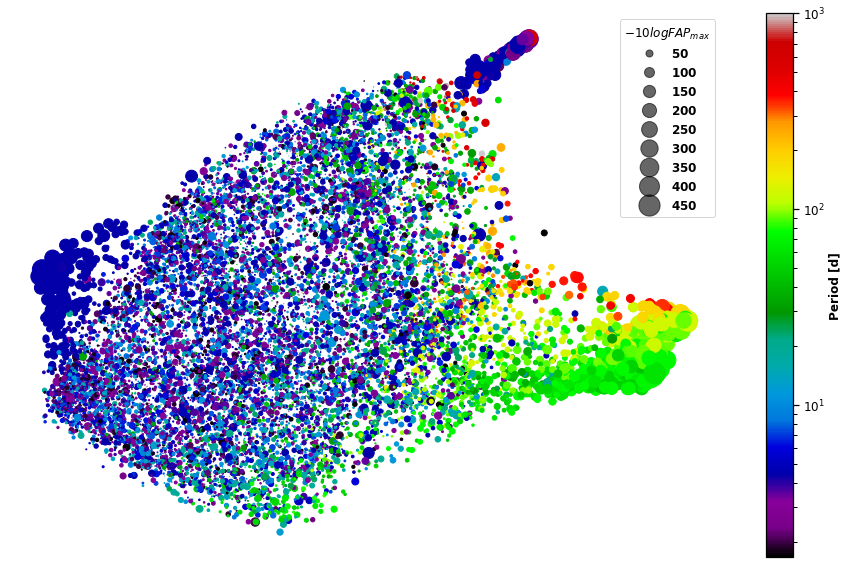

In [37]:
# Record every periodograms
powers = []
mf = []
mp = []
mfap = []
for i in tqdm(range(D2V_all.shape[0])):
    p, m, mmp, f  = periodo(i, D2V_all, sD2V_all, time_grid) 
    powers.append(p)
    mf.append(m)
    mp.append(mmp)
    mfap.append(f)
powers = np.array(powers)
mf = np.array(mf)
mp = np.array(mp)
mfap = np.array(mfap)

# Run clustering
PacMap_map = PacMapDisp(powers)

# Run SVM

In [38]:
def select_per(Per, mxfq):
    U = Per * 0.05
    indlw = []
    for i in range(len(mxfq)):
        if mxfq[i]>Per-U and mxfq[i]<Per+U:
            indlw.append(i)
    return(indlw)

an = 365.25

Pac_an_1  = PacMap_map[select_per(an, mf)]
sample_weight_an_1 = mp[select_per(an, mf)]
size_an_1 = mfap[select_per(an, mf)]
Pac_an_2  = PacMap_map[select_per(an/2, mf)]
sample_weight_an_2 = mp[select_per(an/2, mf)]
size_an_2 = mfap[select_per(an/2, mf)]
Pac_an_3  = PacMap_map[select_per(an/3, mf)]
sample_weight_an_3 = mp[select_per(an/3, mf)]
size_an_3 = mfap[select_per(an/3, mf)]
Pac_prot_1  = PacMap_map[select_per(Prot, mf)]
sample_weight_prot_1 = mp[select_per(Prot, mf)]
size_prot_1 = mfap[select_per(Prot, mf)]
Pac_prot_2  = PacMap_map[select_per(Prot/2, mf)]
sample_weight_prot_2 = mp[select_per(Prot/2, mf)]
size_prot_2 = mfap[select_per(Prot/2, mf)]

Pac_prot = np.concatenate((Pac_prot_1, Pac_prot_2))
sample_weight_prot = np.concatenate((sample_weight_prot_1, sample_weight_prot_2))
size_prot = np.concatenate((size_prot_1, size_prot_2))
Pac_an   = np.concatenate((Pac_an_1, Pac_an_2, Pac_an_3))
sample_weight_an = np.concatenate((sample_weight_an_1, sample_weight_an_2, sample_weight_an_3))
size_an   = np.concatenate((size_an_1, size_an_2, size_an_3))

print(Pac_prot.shape)
print(Pac_an.shape)
weight_ratio = 1#Pac_an.shape[0]/Pac_prot.shape[0]

class_id = np.concatenate((np.zeros_like(Pac_prot.T[0]), np.ones_like(Pac_an.T[0])))
Pac_split = np.concatenate((Pac_prot, Pac_an))
sample_weight = np.concatenate((sample_weight_prot*weight_ratio, sample_weight_an))
size_split = np.concatenate((size_prot*weight_ratio, size_an))

(1728, 2)
(281, 2)


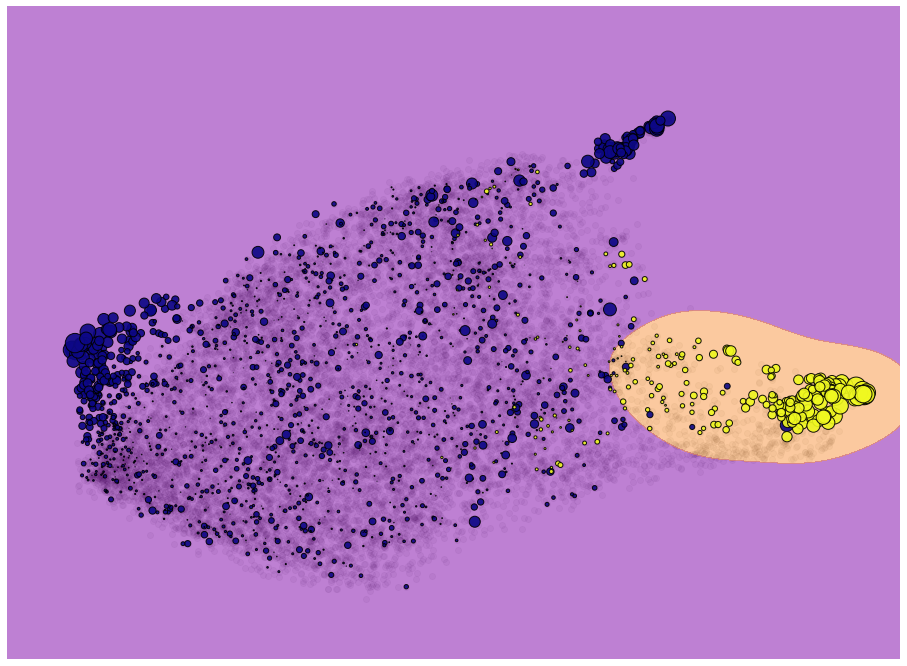

In [39]:
def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-8.5, 12, 500), np.linspace(-8, 11, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, levels=0, alpha=0.5, cmap=plt.cm.plasma)
    axis.scatter(
        Pac_split[:, 0],
        Pac_split[:, 1],
        c=class_id,
        s=10 * size_split,
        alpha=0.9,
        cmap=plt.cm.plasma,
        edgecolors="black",
    )

    axis.axis("off")
    
# Fit the models.

# This other model takes into account some dedicated sample weights.
clf_weights = svm.SVC(kernel='rbf', gamma='auto')
clf_weights.fit(Pac_split, class_id, sample_weight=sample_weight)

fig, axes = plt.subplots(1, 1, figsize=(16, 12))

axes.scatter(PacMap_map[:,0], PacMap_map[:,1], c='k', alpha = 0.05)
plot_decision_function(clf_weights, sample_weight, axes, "Modified weights 1:1")
plt.savefig("/media/paul/One Touch11/Paper1/" +target + "_Toy_modiW2.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Attribute a class for every lines

weights_predi = clf_weights.predict(PacMap_map)


In [40]:
## Select only activity class data
dlw_filtr  = D2V_all[weights_predi == 0]
sdlw_filtr = sD2V_all[weights_predi == 0]
print(dlw_filtr.shape)

# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_d2vs = np.ma.MaskedArray((dlw_filtr), mask=np.isnan((dlw_filtr)))
ma_dd2vs = np.ma.MaskedArray((sdlw_filtr), mask=np.isnan((sdlw_filtr)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_d2vs, weights=1/ma_dd2vs**2, axis=1)
variance = np.ma.average((ma_d2vs-average.reshape(-1, 1))**2, weights=1/ma_dd2vs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_d2vs = average.data.reshape(-1, 1)
std_d2vs = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
RV2 = (np.copy(dlw_filtr)-mean_d2vs)/std_d2vs
dRV2 = np.copy(sdlw_filtr)/std_d2vs

weights = 1. / dRV2 # Not a mistake - The wPCA is coded in a way that 1/dX as a weights variable here means using 1/dX² as an effective weights
weights[np.isnan(RV2)] = 0
pca_filtr = WPCA(n_components=RV2.shape[1])
pca_filtr.fit(RV2, weights=weights)

(14053, 159)


WPCA(n_components=159)

W1before fap  -73.23759724786812
W1before fap  -73.23759724786812
4.3630824753627175


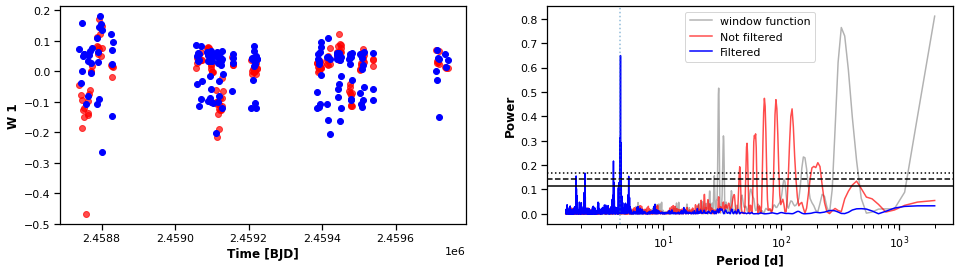

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(time_grid, -pca_d2v.components_[0], 'ro', alpha=0.7)
ax[0].plot(time_grid, -pca_filtr.components_[0], 'bo')
ax[0].set_ylabel(f'W {1}', size=12, weight='bold')
# St the x-axis label
ax[0].set_xlabel('Time [BJD]', size=12, weight='bold')

frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
frequency, power = LombScargle(time_grid, pca_d2v.components_[0]).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'r', alpha=0.7, label='Not filtered')
frequency, power = LombScargle(time_grid, pca_filtr.components_[0]).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'b', label='Filtered')

ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ls = LombScargle(time_grid, pca_filtr.components_[0])
fap = ls.false_alarm_level(0.1)
ax[1].axhline(fap, linestyle='-', color='k')
fap = ls.false_alarm_level(0.01)
ax[1].axhline(fap, linestyle='--', color='k')
fap = ls.false_alarm_level(0.001)
ax[1].axhline(fap, linestyle=':', color='k')
ax[1].axvline(Prot, linestyle=':', alpha=0.5)
ax[1].set_xlabel('Period [d]', size=12, weight='bold')
ax[1].set_ylabel('Power', size=12, weight='bold')
Prow = power[np.argmin(np.abs(frequency - 1/Prot))]
print('W1before fap ', np.log(ls.false_alarm_probability(Prow)))
print('W1before fap ', np.log(ls.false_alarm_probability(power.max())))
freqmaxw1b = np.argmax(power)
print(1/frequency[freqmaxw1b])
ax[1].legend()
plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_ToyModel_beforeafter.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [44]:
print(pearsonr(GP, pca_filtr.components_[0]))
print(pearsonr(BERV, pca_filtr.components_[0]))

PearsonRResult(statistic=-0.8749814219935095, pvalue=2.530650106310968e-51)
PearsonRResult(statistic=0.0658341558636148, pvalue=0.40966568767444506)
